In [148]:
# general imports
import math
import requests as rq

import numpy as np
import pandas as pd
import re
from urllib.request import urlopen
import json
import os
import pathlib
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# pandas formatting 
pd.set_option("display.max_rows", 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# default plotting formats
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
cwd = pathlib.Path.cwd()
air_data_dir = cwd.joinpath("data","air_quality")
NOAH_WKDIR = cwd.joinpath("data","covid")

# load county information for plotly from saved file 
with open('counties.json','r') as jin:
    counties = json.load(jin)



In [4]:
#Does not need to run, just documenting
def load_fips_mapping(file_path=None):
    f2c_map = pd.read_csv('temp.csv', usecols=['fips','county_name','state_name'], dtype={'fips':'string'})
    return f2c_map
    
def request_fips_mapping():
    r = rq.get('https://raw.githubusercontent.com/kjhealy/fips-codes/master/county_fips_master.csv')
    cleaned = r.text.replace('\r\n','\n')
    return cleaned
    # with open('temp.csv', 'w',encoding='utf-8') as tempout:
    #     tempout.write(cleaned)

## Utility functions

In [5]:
def FIPS_function(row):
    state = str(row['State Code']).zfill(2)
    county = str(row['County Code']).zfill(3)
    return str(state + county)
# convert to NO2 ug/m^3 for reference
def no2_mass_by_vol(ppb):
    ugm3 = 1.88*ppb
    return ugm3



def set_daily_cases_deaths(df):
    df['daily_new_cases'] = df['JHU_ConfirmedCases.data'].diff()
    df['daily_new_deaths'] = df['JHU_ConfirmedDeaths.data'].diff()
    return df
# plotting one day's avg 
def show_day_mean(df, date):
    fig = px.choropleth(df[df['Date Local']==date], geojson=counties, locations='fips', color='Arithmetic Mean',
                               color_continuous_scale="Plasma",
                               range_color=(0, 70), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'Arithmetic Mean':'Arithmetic Mean (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig


# plotting one day's max value
def show_day_max(df, date):
    fig = px.choropleth(df[df['Date Local']==date], geojson=counties, locations='fips', color='1st Max Value',
                               color_continuous_scale="Plasma",
                               range_color=(0, 70), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'1st Max Value':'1st Max Value (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig   
def show_sites(df):
    fig = px.choropleth(df, geojson=counties, locations='fips', color='Parameter Code',
                               color_continuous_scale="Plasma",
                               range_color=(0, 1), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'1st Max Value':'1st Max Value (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig

def get_counties_df(file_name='./data/covid/config/counties.json'):
    with open(file_name) as file:
                county_data = json.load(file)
    
    df = pd.DataFrame.from_dict(county_data)
    
    data = [df[col] for col in df.columns]    
    
    # pivot
    return pd.DataFrame(data,columns=df.index, index=df.columns)

def get_fips_from_county_lookup():
    counties = get_counties_df() 
    counties = counties.dropna(subset=['fips'])
    counties.fips = counties.fips.apply(lambda f: eval(str(f)).get('id'))
    counties_index = {k: v for k, v in zip(counties.index, counties.fips)}
    def get_fips_from_county(county):
        return counties_index[county]
    return get_fips_from_county

def daily_avg_county_pollution(df, column_to_avg = "Arithmetic Mean", date_column=None):    
    if date_column == None:
        date_column = 'Date Local'
        avg_by_day = df.groupby([date_column,'fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
    else:
        avg_by_day = df.groupby([date_column,'Date Local','fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
        
        
    return avg_by_day


In [6]:
# FIPS codes from the FCC.  Attempt to match all counties


def make_lookup_functions():
    fcc_county_file = NOAH_WKDIR.joinpath("config","fcc_county_fips.txt")
    with open(fcc_county_file) as fh:
        state = None
        fips_to_county = {}
        county_to_fips = {}
        for row in fh:
            if match := re.match(r'\s+(\d\d\d\d\d)\s+ (.*)', row):
                fips, location = match.groups()
                if fips.endswith('000'):
                    state = location.replace(' ','')
                    continue
                location = location.split(' County')[0]
                location = location.split(' Borough')[0]
                location = location.split(' Census Area')[0]
                location = location.split(' Parish')[0]
                location = location.split(' National Park')[0]
                
                if state == 'Florida' and location == 'Dade':
                    location = 'Miami-Dade'
                if state == 'Massachusetts' and location == 'Dukes':
                    location = 'DukesandNantucket'
                if state == 'Alaska' and location == 'Wrangell-Petersburg':
                    location = 'Wrangell'
                if state == 'Alaska' and location == 'Skagway-Hoonah-Angoon':
                    location = 'Skagway'
                if state == 'Alaska' and location == 'Prince of Wales-Outer Ketchikan':
                    location = 'Prince of Wales'
                if state == 'New York' and location == 'New York':
                    location = 'New York City'
                    
                try:
                    location = ''.join([s[0].upper() + s[1:] for s in location.split(' ')])    
                except Exception as e:
                    pass  # garbage

                county = location.replace(' ', '') + '_' + state + '_UnitedStates'
                fips_to_county[int(fips)] = county
                county_to_fips[county.lower()] = int(fips)
                
        def lookup_county_from_fips(fips_):
            return fips_to_county[int(fips_)]
        
        def lookup_fips_from_county(county_):
            try:
                return county_to_fips[county_.lower()]
            except KeyError:
                pass
            
            try:
                county_ = county_.lower()
                parts = county_.split('_')
                parts[0] = parts[0][:parts[0].index('city')]
                return county_to_fips['_'.join(parts)]
            except:
                pass
            
            try:
                parts = county_.split('_')
                parts[0] = parts[0] +'city'
                return county_to_fips['_'.join(parts)]
            except:
                pass
    
            parts = county_.split('_')
            for k, v in county_to_fips.items():
                part0, part1, _ = k.split('_')
                if part1 != parts[1]:
                    continue
                if parts[0].startswith(part0) or part0.startswith(parts[0]):
                    return v

            raise KeyError
                
        
        return lookup_county_from_fips, lookup_fips_from_county

get_county_from_fips,  get_fips_from_county = make_lookup_functions()

# Loading EPA Data

#### Argument for removing columns
 
We are looking for a link between 2 datasets, for now we will assume things like the 'POC' field (This is the “Parameter Occurrence Code” used to distinguish different instruments that measure the same parameter at the same site.) are unimportant to our investigation.

Similarly we will remove the method code, method name, ect.

more information on the field definitions can be found here -> https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_content_4

In [7]:
# parser warned to use the pd.to_datetime instead
no2_20 = pd.read_csv(air_data_dir.joinpath("no2","daily_no2_2020_with_FIPS.csv"), dtype={'fips':'string'})
# putting datetime in new column out of an abundace of caution
no2_20['Date Local'] = pd.to_datetime(no2_20['Date Local'], format="%Y/%m/%d")

no2_columns = ['Date Local','fips',
               'Arithmetic Mean','AQI',
               '1st Max Value','Units of Measure',
               'Mean ugm3','Site Num',
               'Event Type','Latitude',
               'Longitude','State Code','County Code',
               'Observation Count','Observation Percent']
slim_no2 = no2_20[no2_columns]


## Multiple sample sites in some counties

Some counties have multiple air monitoring stations. Below code builds a dictionary whose keys are the fips codes with multiple sites.

In [8]:
# multiple sites in one county
slim_no2.loc[(slim_no2['Date Local']=='2020-01-01') & (slim_no2['fips']=='06001')].head()

,Date Local,fips,Arithmetic Mean,AQI,1st Max Value,Units of Measure,Mean ugm3,Site Num,Event Type,Latitude,Longitude,State Code,County Code,Observation Count,Observation Percent
4002,2020-01-01,06001,7.865217,17,18.5,Parts per billion,14.786608,7,None,37.687526,-121.784217,6,1,23,96.0
4368,2020-01-01,06001,12.617391,20,21.3,Parts per billion,23.720695,9,None,37.743065,-122.169935,6,1,23,96.0
4733,2020-01-01,06001,15.921739,26,28.0,Parts per billion,29.932869,11,None,37.814781,-122.282347,6,1,23,96.0
5096,2020-01-01,06001,15.934783,22,23.2,Parts per billion,29.957392,12,None,37.793624,-122.263376,6,1,23,96.0
5462,2020-01-01,06001,12.826087,22,23.5,Parts per billion,24.113044,13,None,37.864767,-122.302741,6,1,23,96.0


### A Quick naive solution

... we can average the averages for each county.

This method below achieves this but the other columns are not captured.

In [9]:
county_mean= slim_no2.groupby(['Date Local','fips']).agg({'Arithmetic Mean':'mean'})
county_mean.loc[('2020-01-01','01073')]

Arithmetic Mean    16.373918
Name: (2020-01-01 00:00:00, 01073), dtype: float64

In [10]:
daily_avg_no2 = daily_avg_county_pollution(slim_no2)
daily_avg_no2.head()

Arithmetic Mean  1st Max Value  AQI
Date Local fips                                      
2020-01-01 01073        16.373918           31.0   29
           04013        16.660833           34.0   32
           04019        11.206250           23.7   22
           05035         9.175000           23.1   22
           05119        12.637500           28.9   26

In [11]:
# reset index, then take the year's average per fips (dropping the max value since we want avgs anyway). This will be our benchmark
county_means =daily_avg_no2.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)

### Creating dictonary of the avg ppb and AQI per county for 2020

In [12]:
county_means.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_benchmarks = county_means.to_dict('index')
county_benchmarks['04013']['mean_ppb']

15.218184866848818

# Fix the below.

Need a way to ID the peak pollution days in a manner that lets me check covid data for coorelations.

In [13]:
def check_level(df, averages, delta=0):
    """Return dictonary with higher than average ppb for each fips code.
    
    
    Parameters:
    
    df -- single full dataframe
    
    averages -- dict of structure fips:(mean_ppb, AQI)
    
    delta -- ppb difference to flag, default = 0
    
    The averages dictionary should have one entry per fips code, giving the average concentration for that county.
    
    Return:
    peaks -- dict of structure fips:[dates]
    """
    
    targets = {}
    for fipc in list(averages.keys()):
        df[df['fips']==fipc]
        peak_df = df[(df['fips']==fipc) & (df['Arithmetic Mean'] >= (averages[fipc]['mean_ppb'] + delta))]
        targets[fipc] = peak_df[['Date Local','Arithmetic Mean']].to_dict()
    return targets

In [14]:
flat_daily_avg = daily_avg_no2.reset_index()

In [15]:
# flat_daily_avg.head()
to_cross_ref = check_level(flat_daily_avg, county_benchmarks, delta=15)

In [16]:
cref_keys = list(to_cross_ref.keys())
len(cref_keys)

260

In [17]:
list(to_cross_ref['01073']['Date Local'].values())

[Timestamp('2020-01-08 00:00:00'), Timestamp('2020-12-10 00:00:00')]

The peak times from the above show an increase during the fall/winter months, I would be fine comparing trends into and out of this time period

### Now we can cross check data

With the dict of list of dicts above we can take the key (fips) and the dates within to select the correct data from the covid19 repository and establish a window of effect

- Select fips & date from peak dates
    - Might want to select window of days surrounding the peak
- grab covid data for peak dates
    - will want days leading up to and trailing the peak dates


 

In [146]:
def load_covid_by_fips(fipcode):
    df = pd.read_pickle(NOAH_WKDIR.joinpath("processed_data","county_merged_parts",get_county_from_fips(fipcode)+'.pkl'))   
    return df
clamped_covid = ['fips','JHU_ConfirmedCases.data','JHU_ConfirmedDeaths.data', 
                 'latestTotalPopulation','MaleAndFemale_AtLeast65_Population.data',
                 'Male_Total_Population.data','Female_Total_Population.data',
                 'MaleAndFemale_Under18_Population.data','BLS_EmployedPopulation.data',
                 'BLS_UnemployedPopulation.data','BLS_UnemploymentRate.data',
                 'BLS_LaborForcePopulation.data','AverageWindDirection.data',
                ]

def stringify_fips(row):
    ''' Convert the INTeger representation of fips to a string with leading zeros.
            intended to be used in a lamda function.
            
    Arguments:
    
    row - a single row of a dataframe. Intended to be used like "df4.apply(lambda row: stringify_fips(row), axis=1)"
    
    '''
    strFips = str(row['fips']).zfill(5)
    return strFips

def rolling_cases(df, window_size=7):
    df['1wkroll'] = df['daily_new_cases'].rolling(window=window_size).mean()
    df.reset_index(inplace=True)
    df.set_index("dates",inplace = True)
    return df

# cases / 100,000 people
def set_weighted_cases(df):
    wpop =  df['latestTotalPopulation'].max()/100000
    z = covdf.loc[:,'JHU_ConfirmedCases.data'] / wpop
    df['total_cases_per_100k'] = z.values    
    return df

#deaths per person infected
def set_death_per_cases(df):
    df.loc[:,'deaths_per_cases']= np.where((df.loc[:,'JHU_ConfirmedDeaths.data'] / df.loc[:,'JHU_ConfirmedCases.data'])>=0,
                                          (df.loc[:,'JHU_ConfirmedDeaths.data'] / df.loc[:,'JHU_ConfirmedCases.data']), 0)
    return df
    

In [19]:
# Collect list of dates for the target county
target_fips = '01073'
c_dates = list(to_cross_ref['01073']['Date Local'].values())

In [257]:
def load_and_augment_fips(fips):
    tdf = load_covid_by_fips(fips)
    # pickle loads numbers as floats; converting fips to int
    tdf['fips'] = tdf.apply(lambda row: math.floor(row['fips']), axis=1)

    # Making fips a string to match on other datasets with leading zero
    df2= tdf.astype({"fips":"int"}).astype({'fips':'string'})
    
    # adding leading zero where needed
    df2['fips'] = df2.apply(lambda row: stringify_fips(row), axis=1)
    
    #need daily change in cases to get the rolling delta of new infections
    df2 = set_daily_cases_deaths(df2)
    df2 = rolling_cases(df2)
    df2.index = pd.to_datetime(df2.index, format="%Y/%m/%d")
    top_level_covid = ['fips','daily_new_cases','daily_new_deaths', "1wkroll",
                   'JHU_ConfirmedCases.data','JHU_ConfirmedDeaths.data', 
                   'latestTotalPopulation']
    
    
    df3 = df2[top_level_covid].copy()
    df3 = set_weighted_cases(df3)
    df3 = set_death_per_cases(df3)
    
    del df2
    del tdf

    
    
    return df3

In [259]:
covdf2 = load_and_augment_fips("01073")
bsdf = load_and_augment_fips("04013")

In [260]:
bsdf.head()

,fips,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
dates,,,,,,,,,
2020-01-01,04013,NaN,NaN,NaN,0.0,0.0,4485414.0,0.0,0.0
2020-01-02,04013,0.0,0.0,NaN,0.0,0.0,4485414.0,0.0,0.0
2020-01-03,04013,0.0,0.0,NaN,0.0,0.0,4485414.0,0.0,0.0
2020-01-04,04013,0.0,0.0,NaN,0.0,0.0,4485414.0,0.0,0.0
2020-01-05,04013,0.0,0.0,NaN,0.0,0.0,4485414.0,0.0,0.0


In [145]:
no2df = daily_avg_no2.reset_index().set_index("Date Local")

## Datetime Index conditions

In [40]:
no2df[['Arithmetic Mean']][no2df['fips'] == '01073'].loc['2020-12-01':'2020-12-20']

,Arithmetic Mean
Date Local,
2020-12-01,14.980952
2020-12-02,19.790476
2020-12-03,14.652976
2020-12-04,7.270347
2020-12-05,11.602083
2020-12-06,14.316667
2020-12-07,8.619508
2020-12-08,16.688095
2020-12-09,21.626190


## Leveraging the datetime functionality in pandas

In [151]:
tdate = pd.Timestamp('2020-12-10')
# days forward and backward to look
offset = pd.offsets.Week()

<Figure size 720x576 with 0 Axes>

In [152]:
no_vals = no2df[no2df['fips'] == '01073'].loc[tdate - offset:tdate+offset]["Arithmetic Mean"]
cov_interval = covdf.loc[tdate - offset:tdate+offset]

<AxesSubplot:xlabel='dates'>

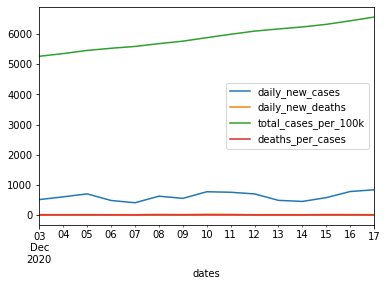

In [153]:
cov_interval[['daily_new_cases','daily_new_deaths','total_cases_per_100k','deaths_per_cases']].plot()



# idx = pd.date_range(start="2020-12-20", freq="D", periods=7)
# no2df[no2df['fips']=='01073'].loc[idx]
# no2df[['Arithmetic Mean']][no2df['fips'] == '01073'].loc[tdate:'2020-12-20']

In [ ]:
get_county_from_fips('01073')

'Jefferson_Alabama_UnitedStates'

In [ ]:
covdf.describe()

,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
count,653.000000,653.000000,647.000000,654.000000,654.000000,654.0,654.000000,654.000000
mean,154.673813,2.531394,156.108192,41899.032110,754.331804,658573.0,6362.093816,0.019220
std,231.814520,6.178158,184.878883,36640.732402,659.360063,0.0,5563.655419,0.012876
min,-39.000000,-2.000000,0.000000,0.000000,0.000000,658573.0,0.000000,0.000000
25%,0.000000,0.000000,22.285714,2356.750000,117.000000,658573.0,357.857064,0.015784
50%,67.000000,0.000000,84.285714,30469.000000,491.000000,658573.0,4626.518245,0.018404
75%,187.000000,2.000000,220.285714,76283.500000,1516.750000,658573.0,11583.150235,0.019552
max,2026.000000,58.000000,752.142857,101002.000000,1653.000000,658573.0,15336.492689,0.058745


In [141]:
tcase_for_pop = covdf["JHU_ConfirmedCases.data"].max()/covdf["latestTotalPopulation"].max()
tcase_for_pop

0.15336492689496836

### Verify values

According to the [nytimes covid information](https://www.nytimes.com/interactive/2021/us/covid-cases.html), Jefferson Alabama (Fips = '010173') has a total case number = 1 in 6 of the population and deaths 1 in 330

In [144]:
print(f"given the estimate of {1/6} from the nyt, we found a case rate of {tcase_for_pop} for the population of Jefferson county")

given the estimate of 0.16666666666666666 from the nyt, we found a case rate of 0.15336492689496836 for the population of Jefferson county


In [165]:
# for each fips we want to examine we can call -> load_and_augment_fips('fips')
no2_rolling_mean = no2df.groupby("fips")[['Arithmetic Mean']].rolling(window=3).mean()
temp = no2_rolling_mean.groupby("fips").idxmax()

In [186]:
first_case_date = pd.Timestamp('2020-1-20')
ex_dict = {}
for artup in temp.values:
    tup = artup[0]
    ex_dict[tup[0]] = tup[1]

In [192]:
no2fips=list(ex_dict.keys())

In [203]:
tlist = []
for fip in no2fips:
    if ex_dict[fip] > first_case_date+(4*pd.offsets.Week()):
        tlist.append(fip)
print(len(tlist))
    

161


In [246]:
ex_dict['01073']

Timestamp('2020-01-30 00:00:00')

### taking stock
I currently have
- list of fips codes that have very hi break above 

In [207]:
# confirming that +15 ppb is actually above the std div
stdList = flat_daily_avg.groupby("fips")['Arithmetic Mean'].std()
stdList[:10]

fips
01073    4.487149
04013    6.220100
04019    3.936105
05035    3.444462
05119    3.568080
06001    5.764433
06007    3.266836
06013    3.525177
06019    5.229202
06023    1.469440
Name: Arithmetic Mean, dtype: float64

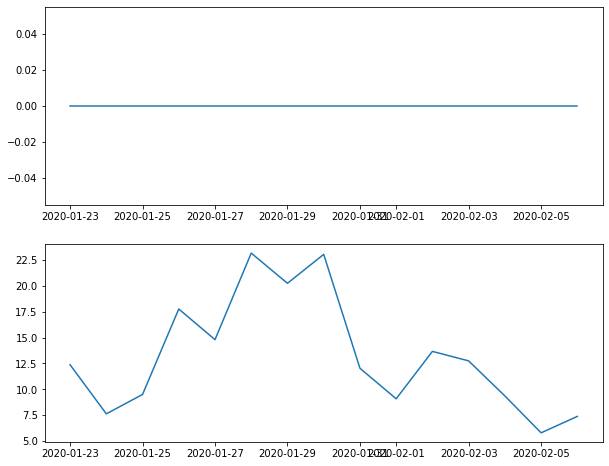

In [275]:
tfip = "01073"
center_date = ex_dict[tfip]
covdf2 = load_and_augment_fips(tfip)
fig, axs = plt.subplots(2,1,figsize =(10,8) )
no2_vals = no2df[no2df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
cov_interval = covdf2.loc[center_date - offset:center_date+offset]

axs[0].plot(cov_interval['daily_new_cases'])
axs[1].plot(no2_vals)


In [273]:
cov_interval['daily_new_cases']

dates
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    0.0
2020-01-27    0.0
2020-01-28    0.0
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
2020-02-01    0.0
2020-02-02    0.0
2020-02-03    0.0
2020-02-04    0.0
2020-02-05    0.0
2020-02-06    0.0
Name: daily_new_cases, dtype: float64

In [274]:
no2_vals

Date Local
2020-01-23    12.373814
2020-01-24     7.622727
2020-01-25     9.498214
2020-01-26    17.765720
2020-01-27    14.799784
2020-01-28    23.171754
2020-01-29    20.252277
2020-01-30    23.050909
2020-01-31    12.035172
2020-02-01     9.079166
2020-02-02    13.664962
2020-02-03    12.746537
2020-02-04     9.354871
2020-02-05     5.787845
2020-02-06     7.375541
Name: Arithmetic Mean, dtype: float64

In [270]:
covdf2.head()

,fips,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
dates,,,,,,,,,
2020-01-01,01073,NaN,NaN,NaN,0.0,0.0,658573.0,0.0,0.0
2020-01-02,01073,0.0,0.0,NaN,0.0,0.0,658573.0,0.0,0.0
2020-01-03,01073,0.0,0.0,NaN,0.0,0.0,658573.0,0.0,0.0
2020-01-04,01073,0.0,0.0,NaN,0.0,0.0,658573.0,0.0,0.0
2020-01-05,01073,0.0,0.0,NaN,0.0,0.0,658573.0,0.0,0.0


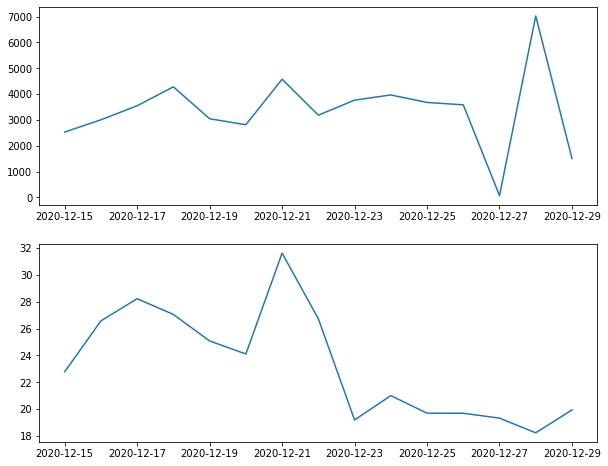

In [278]:
tfip = "04013"
center_date = ex_dict[tfip]

covdf2 = load_and_augment_fips(tfip)
fig, axs = plt.subplots(2,1,figsize =(10,8))
no2_vals = no2df[no2df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
cov_interval = covdf2.loc[center_date - offset:center_date+offset]

axs[0].plot(cov_interval['daily_new_cases'])
axs[1].plot(no2_vals)


In [283]:
bama_no2 = no2df[no2df['fips'] == tfip][["Arithmetic Mean"]].copy()

joined = bama_no2.join(covdf2[['daily_new_cases','daily_new_deaths','total_cases_per_100k','deaths_per_cases','JHU_ConfirmedCases.data','JHU_ConfirmedDeaths.data']], lsuffix='no2', rsuffix='covid')

In [284]:
joined.head()

,Arithmetic Mean,daily_new_cases,daily_new_deaths,total_cases_per_100k,deaths_per_cases,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data
Date Local,,,,,,,
2020-01-01,16.660833,NaN,NaN,0.0,0.0,0.0,0.0
2020-01-02,17.936087,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,23.325000,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,22.095000,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,19.048333,0.0,0.0,0.0,0.0,0.0,0.0


In [285]:
joined.corr()

,Arithmetic Mean,daily_new_cases,daily_new_deaths,total_cases_per_100k,deaths_per_cases,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data
Arithmetic Mean,1.000000,0.123461,-0.057472,0.426069,-0.216006,0.348436,0.369234
daily_new_cases,0.123461,1.000000,0.513942,0.606591,0.031260,0.609061,0.502963
daily_new_deaths,-0.057472,0.513942,1.000000,0.387577,0.114752,0.459493,0.384286
total_cases_per_100k,0.426069,0.606591,0.387577,1.000000,0.122336,0.983137,0.959129
deaths_per_cases,-0.216006,0.031260,0.114752,0.122336,1.000000,0.124182,0.188429
JHU_ConfirmedCases.data,0.348436,0.609061,0.459493,0.983137,0.124182,1.000000,0.978638
JHU_ConfirmedDeaths.data,0.369234,0.502963,0.384286,0.959129,0.188429,0.978638,1.000000


In [237]:
covdf.columns

Index(['fips', 'daily_new_cases', 'daily_new_deaths', '1wkroll', 'JHU_ConfirmedCases.data', 'JHU_ConfirmedDeaths.data', 'latestTotalPopulation', 'total_cases_per_100k', 'deaths_per_cases'], dtype='object')

In [238]:
cor_covid = covdf[['daily_new_cases','daily_new_deaths','total_cases_per_100k']]